In [10]:
import matplotlib.pyplot as plt
import random
import torch
import torchvision
import torchinfo

from pathlib import Path
from torch import nn
from torchvision import transforms

from pytorch_playground.utils import data_setup, model_builder, plotting, train_model, save_model


In [11]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.1
torchvision version: 0.16.1


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

In [14]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # from ImageNet data
                         std=[0.229, 0.224, 0.225]) # # from ImageNet data
])

In [15]:
# pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [16]:
# get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                                                                train_dir=train_dir,
                                                                test_dir=test_dir,
                                                                transform=auto_transforms, # or manual_transforms
                                                                batch_size=32,
                                                                )

In [ ]:
'''
If you're using macOS go to Macintosh HD > Applications > Python3.X folder --> double click on "Install Certificates.command"
'''

In [18]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
torch.manual_seed(42)
# device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=10, 
                              output_shape=len(class_names)).to(device)

In [19]:
# Print a summary using torchinfo
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [20]:
# freeze all base layers in the features section of the model
for param in model.features.parameters():
    param.requires_grad = False

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
from timeit import default_timer as timer 
start_time = timer()

results = train_model.train(model=model, 
                            train_dataloader=train_dataloader, 
                            test_dataloader=test_dataloader, 
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=5,
                            device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:20<05:23, 80.91s/it]

Epoch: 1 | train_loss: 1.0422 | train_acc: 0.4883 | test_loss: 0.8629 | test_acc: 0.7027


 40%|████      | 2/5 [02:41<04:01, 80.62s/it]

Epoch: 2 | train_loss: 0.9235 | train_acc: 0.5898 | test_loss: 0.7864 | test_acc: 0.7225


 60%|██████    | 3/5 [04:02<02:41, 80.69s/it]

Epoch: 3 | train_loss: 0.7637 | train_acc: 0.7266 | test_loss: 0.6836 | test_acc: 0.9271


 80%|████████  | 4/5 [05:22<01:20, 80.60s/it]

Epoch: 4 | train_loss: 0.6775 | train_acc: 0.8945 | test_loss: 0.6391 | test_acc: 0.9167


100%|██████████| 5/5 [06:43<00:00, 80.69s/it]

Epoch: 5 | train_loss: 0.6591 | train_acc: 0.7539 | test_loss: 0.6374 | test_acc: 0.7841
Total training time: 403.457 seconds


In [25]:
def plot_loss_curves2(results):
    """
    Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = [x.item() for x in results['train_loss']]
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

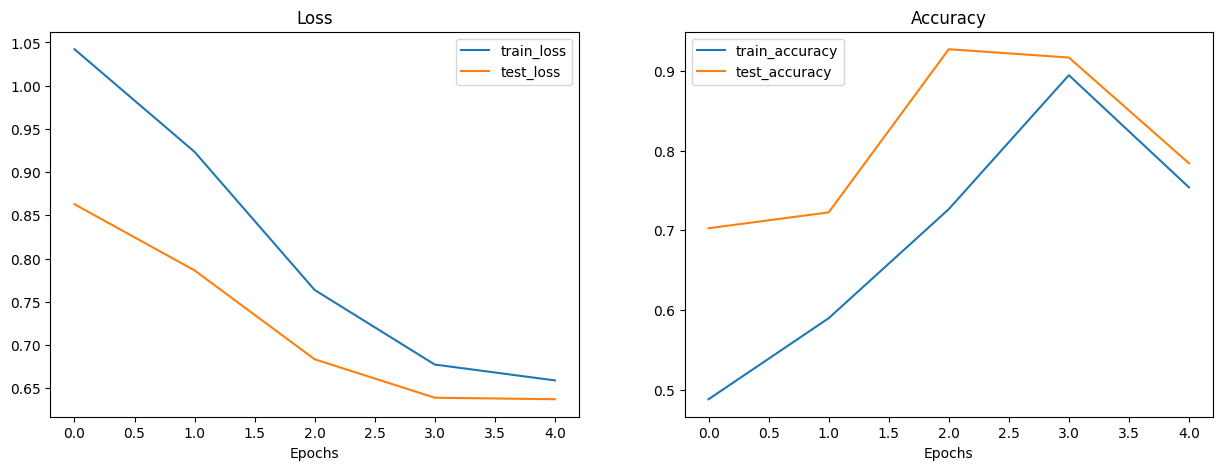

In [26]:
#plotting.plot_loss_curves(results)
plot_loss_curves2(results)

In [27]:
list(Path(test_dir).glob("*/*.jpg"))[0:5]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')]

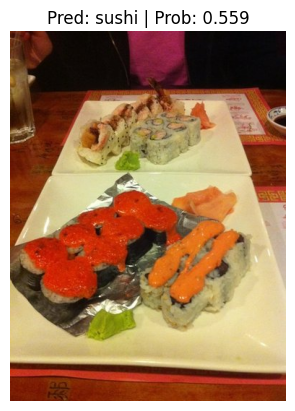

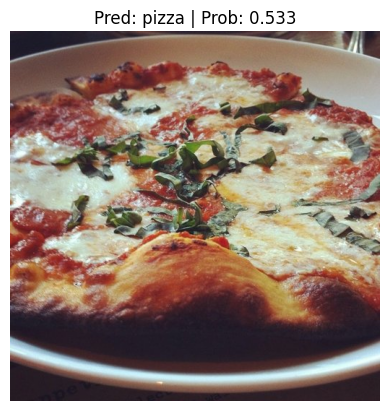

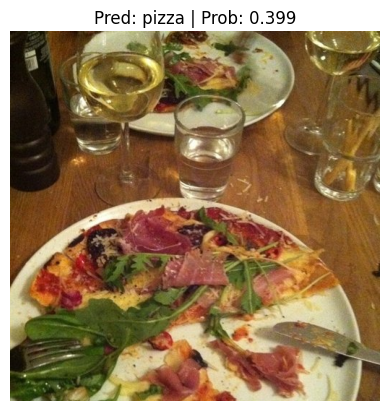

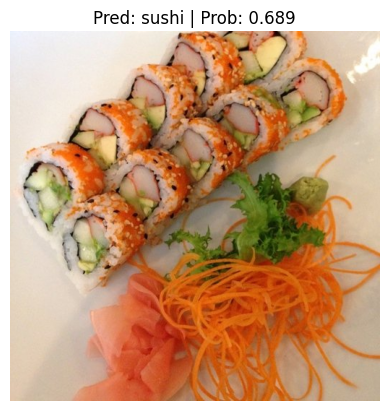

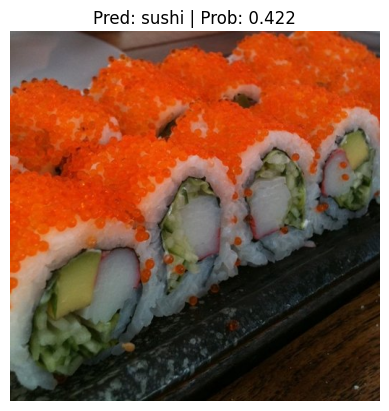

In [28]:
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

# Make predictions
for image_path in test_image_path_sample:
    plotting.pred_and_plot_image(model=model, 
                                        image_path=image_path,
                                        class_names=class_names,
                                        transform=weights.transforms(),
                                        image_size=(224, 224))

In [ ]:
save_model(model=...
           target_dir=...,
           model_name=...)